In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mysql.connector as connection
import os
import seaborn as sns

# Suppressing matplotlib and pandas warings
import warnings
warnings.filterwarnings("ignore")


Matplotlib is building the font cache; this may take a moment.


Connecting to database

In [2]:
from dotenv import load_dotenv

# Loading data used for connecting to database
load_dotenv()

connector = connection.connect(
    user=os.getenv("DB_USER"),
    database=os.getenv("DB_NAME"),
    host=os.getenv("DB_HOST"),
    password=os.getenv("DB_PASSWORD")
    )

Data base model

<img title="a title" alt="Alt text" src="mysql-sample-database.png">

List of countries

In [3]:
countries = pd.read_sql(
    """
    SELECT DISTINCT country
    FROM customers
    ORDER BY country
    """, connector)
countries

,country
0,Australia
1,Austria
2,Belgium
3,Canada
4,Denmark
5,Finland
6,France
7,Germany
8,Hong Kong
9,Ireland


Best selling countries

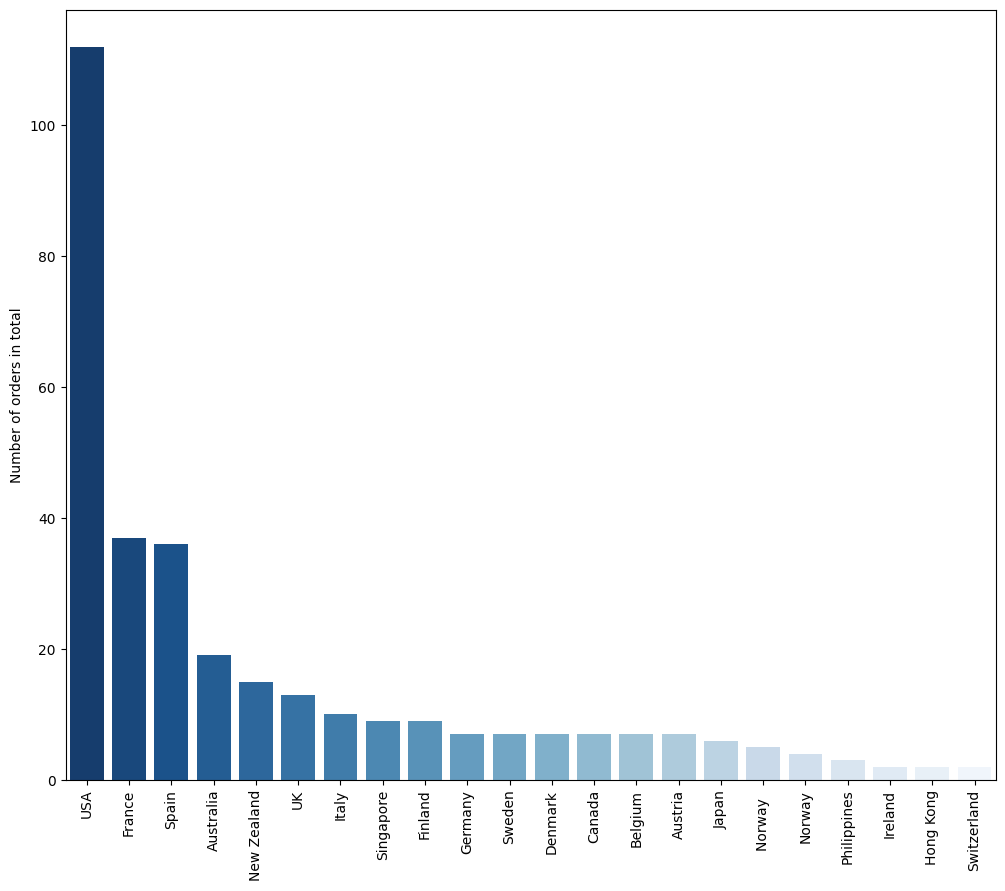

In [4]:
bestSellingCountries = pd.read_sql(
    """
    SELECT
        customers.country,
        COUNT(orders.orderNumber) AS totalOrders
    FROM customers
    INNER JOIN orders 
    ON customers.customerNumber = orders.customerNumber
    GROUP BY customers.country
    ORDER BY totalOrders DESC
    """, connector)

# Visualisation of best selling countries
vis = plt.figure(figsize=(12,10))
vis = sns.barplot(x=bestSellingCountries["country"],y=bestSellingCountries["totalOrders"],palette='Blues_r')
vis = plt.xticks(rotation=90)
vis = plt.xlabel("")
vis = plt.ylabel("Number of orders in total")

Best selling products

In [13]:
bestSellingProducts = pd.read_sql(
    """
    SELECT 
        products.productName, 
        SUM(orderdetails.quantityOrdered) AS totalQuantity
    FROM products
    INNER JOIN orderDetails 
    ON products.productCode = orderdetails.productCode
    INNER JOIN orders
    ON orderdetails.orderNumber = orders.orderNumber
    GROUP BY products.productName
    ORDER BY totalQuantity DESC;
    """, connector)

bestSellingProducts["totalQuantity"] = bestSellingProducts["totalQuantity"].astype(int)
bestSellingProducts.head(n=10)

,productName,totalQuantity
0,1992 Ferrari 360 Spider red,1808
1,1937 Lincoln Berline,1111
2,American Airlines: MD-11S,1085
3,1941 Chevrolet Special Deluxe Cabriolet,1076
4,1930 Buick Marquette Phaeton,1074
5,1940s Ford truck,1061
6,1969 Harley Davidson Ultimate Chopper,1057
7,1957 Chevy Pickup,1056
8,1964 Mercedes Tour Bus,1053
9,1956 Porsche 356A Coupe,1052


Distribution of categories

Time series for sales

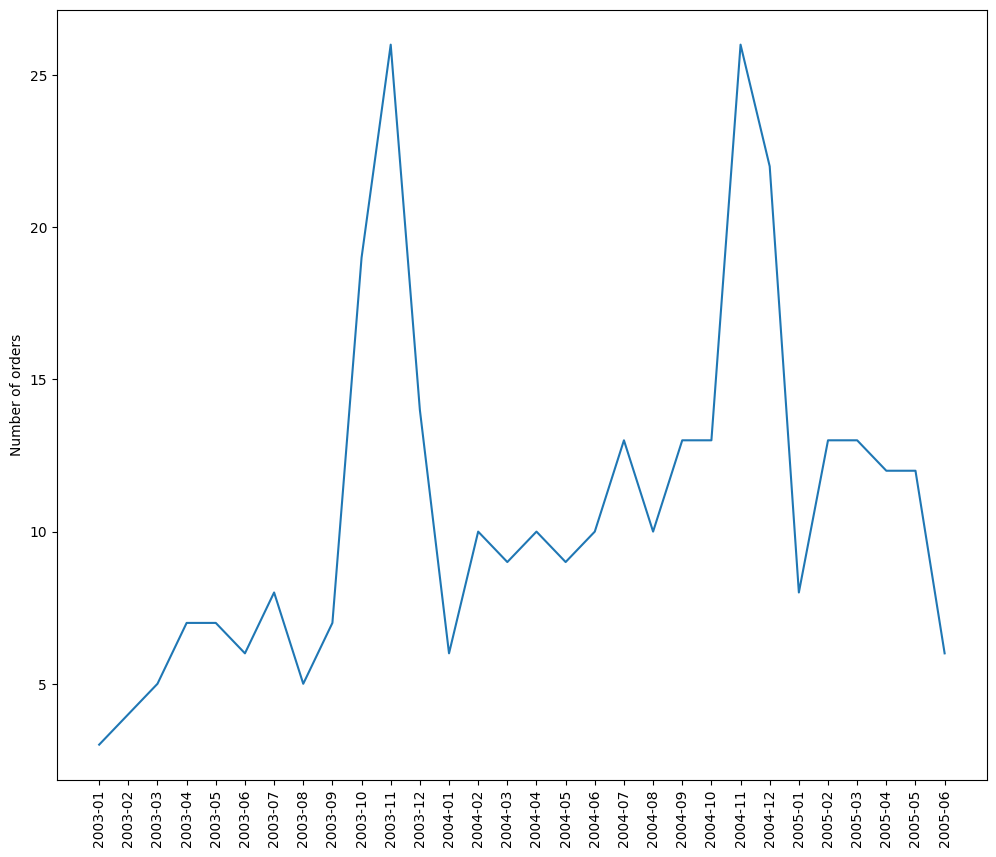

In [19]:
# We get date in format Year - Month
salesInTime = pd.read_sql(
    """
    SELECT 
        COUNT(orderNumber) AS orderCount,
        DATE_FORMAT(requiredDate, '%Y-%m') AS date
    FROM orders
    GROUP BY date
    ORDER BY date
    """, connector)

# Visualisation of sales in time
vis1 = plt.figure(figsize=(12,10))
vis1 = sns.lineplot(x=salesInTime["date"], y=salesInTime["orderCount"])
vis1 = plt.xticks(rotation=90)
vis1 = plt.xlabel("")
vis1 = plt.ylabel("Number of orders")
